# Representaciones vectoriales de palabras y oraciones: text embeddings

### Procesamiento del Lenguaje Natural

**Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

In [26]:
%matplotlib inline  
# Figures plotted inside the notebook
%config InlineBackend.figure_format = 'retina'
# High quality figures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc

# Configuración de las figuras matplotlib
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 12})

# 1. Introducción

Un *embedding* es una representación vectorial de nuestros datos en un espacio de dimensión **relativamente bajo**. La representación mediante *embeddings* suele utilizarse para facilitar el aprendizaje de modelos cuando se tienen que manejar datos categóricos o conceptos cuya codificación suele llevar a representaciones *sparse* de alta dimensión, como pueden ser codificaciones one-hot encoding de variables categóricas estandar o  representaciones BoW o TF-IDF de documentos. 

Así, por ejemplo, una codificación one-hot de paises y ciudades nos llevaría a vectores de este tipo:

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/OneHotEncoding.png" width="40%"> 


Al utilizar este tipo de representaciones en un sistema de aprendizaje automático nos encontramos varias limitaciones:
* Por un lado, trabajar con un espacio de **muy alta dimensión** implica entrenar un modelo con muchos parámetros, lo que a su vez conlleva un mayor coste computacional, riesgo de sobreajuste, ...
* Por otro lado, el tener que manejar representaciones dispersas dificulta el cálculo de distancias entre elementos así como la **identificación de elementos similares**. Por ejemplo, la codificación anterior nos va a dar la misma distancia entre Rome y Paris que entre Rome e Italia.

Por tanto, para utilizar este tipo de representaciones en un sistema de aprendizaje automático, necesitamos una forma de representar cada vector disperso como un vector de números para el que los elementos semánticamente similares (ciudades, películas o palabras) tengan distancias similares en el espacio vectorial. La solución a estos problemas es utilizar *embeddings*, ya que son capaces de transformar grandes vectores dispersos a un espacio de menor dimensión que preserva las relaciones semánticas. 

Idealmente, un buen *embedding* debe proporcionar un conjunto de vectores cuya posición (distancia y dirección) en el espacio vectorial codifique la semántica de los datos que representan. Las siguientes visualizaciones$^{(*)}$ de *embeddings* reales muestran relaciones geométricas que capturan relaciones semánticas como el genero, un tiempo verbal o la relación entre un país y su capital

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/Embeddings1.svg" width="80%"> 

Además, la representación de los datos mediante  *embeddings* tiene varias ventajas:
* Ayuda al aprendizaje del modelo, ya que reducirá el coste computacional y evitará problemas de sobreajuste.  
* Esta representación puede aprenderse y reutilizarse en distintos modelos.
* Al manejar los datos en un espacio de menor dimensión se facilita su representación, ya sea porque el *embedding* nos permite tener los datos en un espacio de dos o tres dimensiones, o porque se puede combinar con algoritmos de visualización (que veremos más adelante) que nos permiten visualizar lo que está ocurriendo en este espacio del *embedding*.

$^{(*)}$ https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space


En la sesión de hoy, estudiaremos los siguientes aspectos relacionados con *embeddings* de texto:
- Modelo **Word2Vec** para entrenar *word embeddings*. 
    - Entrenamiento de Word2Vec con gensim. 
    - Modelos Word2Vec pre-entrenados en gensim y spaCy.
- Otras aproximaciones a word embeddings: **CBoW, Glove, FastText**. Uso de modelos pre-entrenados.
- **Text embeddings (embeddings para documentos)**  con Doc2Vec y gensim.

# 2. Embeddings de palabras con Wor2Vec

[Word2vec](https://arxiv.org/pdf/1310.4546.pdf) utiliza un tipo muy sencillo de **red neuronal** para aprender asociaciones de palabras de un gran corpus de texto. Word2vec se basa en la premisa de que palabras con significado similar deben ser codificadas con vectores geométricamente cercanos. Para ello se considera que las palabras que suelen tener las mismas palabras vecinas (contexto) tienden a ser semánticamente similares. Tanto "perro" como "gato" aparecen con frecuencia cerca de la palabra "veterinario", y este hecho refleja su similitud semántica. 

Si bien en general vamos a utilizar librerías y modelos pre-entrenados, presentaremos wor2vec como ejemplo representativo de modelo de red neuronal aplicado a NLP. Para ello, revisamos brevemente **regresión logística para clasificación** y su extensión a Wor2Vec.

Hay diferentes esquemas para construir un word2vec, aquí vamos a ver el modelo más común que es el **Skip-Gram**.

## 2.1 Revisión: regresión logística binaria

Supongamos que tenemos un conjunto de datos de entrenamiento $(\mathbf{x}_i,y_i)$ donde $\mathbf{x}_i\in\mathbf{R}^m$ e $y_i\in\{0,1\}$.


En regresión logística (en adelante RL) aproximamos la probabilidad de la etiqueta $y$ usando una **combinación lineal** de las entradas $\bf x$:

$$P(y=1| {\bf x}) =  \frac{1}{1+\exp(-({\bf w}^T {\bf x}+w_0))}=\sigma({\bf w}^T {\bf x}+w_0)$$
$$$$
$$ P(y=0| {\bf x}) = 1- P(Y=y| {\bf x}) = 1 - \sigma({\bf w}^T {\bf x}+w_0)$$

donde 

- $w_0$ y ${\bf w} = [w_1, \ldots, w_D]$ son parámetros que aprenderemos usando el conjunto de datos de entrenamiento $(\mathbf{x}^{(i)},y^{(i)})_{i=1,\ldots,N}$.
$$$$
- $\sigma(a) = \frac{1}{1+\exp(-a)}$ es la función sigmoide.
$$$$


#### Función de coste

Para seleccionar el vector $\mathbf{w}$, RL resuelve el siguiente problema de optimización:

$$l({\bf w}) = \sum_{i=1}^N \left\lbrace  y^{(i)}\log \left(  P(y=1| {\bf x}^{(i)})\right)  + (1-y^{(i)}) \log\left(  1- P(y=1| {\bf x}^{(i)}) \right)  \right\rbrace $$

$${\bf w}^* =\displaystyle \underset{{\bf w}}{\operatorname{max}} l({\bf w})$$

- Que no es más que intentar alinear las regiones de probabilidades constantes con **las probabilidades de las etiquetas reales**.
- Este problema no tiene solución cerrada. Se resuelve con optimización numérica.


## 2.2 Revisión: regresión logística multiclase

Supongamos ahora que tenemos etiquetas con $K$ posibles valores: $y_i \in\{1,\ldots,K\}$. RL formula ahora del siguiente modo:

\begin{align}
P(y=k|\mathbf{x}) = \frac{\text{e}^{z_k}}{\sum_{j=1}^{K}\text{e}^{z_j}}, k =1,\ldots,K
\end{align}
donde el vector $\mathbf{z} = \left[z_1,\ldots,z_K\right]$ se calcula como

$$\mathbf{z} = \mathbf{W}\mathbf{x} + \mathbf{w}_0$$

siendo $\mathbf{W}$ una matriz real de dimensiones $K\times m$ y $\mathbf{w_0}$ un vector de dimensiones $K \times 1$.

La función de coste es esencialmente la misma, acumulamos el logaritmo de la probabilidad que damos a cada etiqueta real:

$$l({\bf W,w_0}) = \sum_{i=1}^N \sum_{j=1}^{K} \log \left(  P(Y=k| {\bf x}^{(i)})\right) \mathbb{1}[y^{(i)}==k]$$


$${\bf W^*,w^*_0} =\displaystyle \underset{{\bf W,w_0}}{\operatorname{max}} l({\bf W,w_0})$$


## 2.3 Modelo Skip-Gram 

Supongamos que se tiene una ventana deslizante de tamaño fijo que se desplaza a lo largo de una frase: la palabra del centro es el **objetivo** y las que están a su izquierda y derecha dentro de la ventana deslizante son las palabras de **contexto**. 

Consideremos el siguiente ejemplo donde usamos una ventana de tamaño 5 para ir construyendo nuestras muestras de entrenamiento con pares de palabras (objetivo, contexto):

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/word2vec1.png" width="80%"> 

A partir de este conjunto de datos, el modelo Skip-Gram se entrena para predecir las probabilidades de que una palabra sea el contexto de un determinado objetivo. Para ello utiliza una **una regresión logística multiclase**, con la particularidad de que **la entrada al clasificador no es directamente la codificación one-hot** de cada palabra, sino un vector real de dimensión $D<<V$ que se aprende junto a los parámetros de la regresión logística. Este vector es el word embedding de dicha palabra. 

Al reducir la dimensión a la entrada, hacemos que el número de parámetros que tentemos que entrenar pase de **$V^2$ a $2D\times V$**. La estructura final, que mostramos a continuación, es un tipo de **red neuronal** muy sencilla.


<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/word2vec3.png" width="80%"> 

Las palabras objetivo ($x_1$, ..., $x_v$) están a la entrada de la red con una codificación one-hot. Las palabras contexto ($y_1$, ..., $y_v$) son el objetivo y están a la salida también con una codificación one-hot. De este modo la red, para cada par (objetivo, contexto) debe predecir el contexto de la palabra objetivo. Para ello, la red tiene una capa intermedia que permite modelar el contexto a partir del objetivo. El tamaño de esta capa ($D$) define el tamaño o dimensión de nuestro embedding; para procesado de texto suelen usarse embedding de tamaño 100, 200,... aunque lógicamente esto depende de la complejidad de la base de datos.

Usando así el conjunto de entrenamiento que generamos con el corpus de datos, se entrenará la red y se aprenderán los parámetros de red dados por las matrices de entrada $W$ y la de salida $W'$. Mientras que la matriz de salida codifica el contexto, la matriz de entrada (denominada *embedding*) nos da una representación en un espacio de tamaño $D$ de cada una de las palabras objetivo en nuestro corpus. 



**Carga de datos** 

Para empezar a trabajar con este modelo vamos a empezar utilizando uno de los datasets de NLTK. En este caso elegimos el dataset *Reuters Corpus* que contiene 10.877 noticias sobre finanzas y un total de 1.3 millones de palabras. Los documentos están clasificados en 90 categorías.

Si en Google colab os da un error al descargar `reuters` hay que forzar que carge la última versión de la librería


In [27]:
# !pip install --user -U nltk

In [28]:
import nltk
from nltk.corpus import reuters

# download all dependencies and corpora 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('reuters')

print(reuters.categories())


['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


[nltk_data] Downloading package punkt to /Users/olmos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/olmos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/olmos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/olmos/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/olmos/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package reuters to /Users/olmos/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [29]:
# En google colab hay que descomprimir el paquete reuters

#!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Vamos a quedarnos con noticias sobre comercio de cereales ...

In [30]:
reuters_raw = [reuters.raw(f) for f in reuters.fileids(['barley', 'corn', 'wheat', 'grain'])]

In [31]:
print(f"Hay un total de {len(reuters_raw)} documentos. El primero de ellos es:\n")

print(reuters_raw[0])

Hay un total de 585 documentos. El primero de ellos es:

CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS
  A survey of 19 provinces and seven cities
  showed vermin consume between seven and 12 pct of China's grain
  stocks, the China Daily said.
      It also said that each year 1.575 mln tonnes, or 25 pct, of
  China's fruit output are left to rot, and 2.1 mln tonnes, or up
  to 30 pct, of its vegetables. The paper blamed the waste on
  inadequate storage and bad preservation methods.
      It said the government had launched a national programme to
  reduce waste, calling for improved technology in storage and
  preservation, and greater production of additives. The paper
  gave no further details.
  




A continuación vamos a normalizar el texto únicamente pasando todo a minúsculas, pero podríamos lógicamente aplicar todo el preprocesado que hemos visto para mejorar el resultado del embedding que calculemos.

In [32]:
import spacy

nlp = spacy.load("en_core_web_md")

reuters_tok = [[w.text.lower() for w in nlp(d)] for d in reuters_raw]

### Word Embeddings pre-entrenados en spaCy

Los distintos [pipelines accesibles a través de spaCy](https://spacy.io/models/en) incluyen también word embeddings pre-entrenados, muchos de ellos usando fastText:

In [33]:
#!python -m spacy download es_core_news_md

In [34]:
lista_vocab = list(nlp.vocab.strings)

print("El tamaño del diccionario es de {} palabras".format(len(lista_vocab)))

#Las 100 primeras
print(lista_vocab[:100])

El tamaño del diccionario es de 709799 palabras
['\t', '\n', ' ', '  ', '!', '!!', '!!!', '!!!!', '!!!!!!!!!!!!!!!!', '!!!!.', '!!.', '!!?', '!!??', '!*', '!.', '!?', '!??', '!ck', '!nk', '"', '""', '#', '##', '###', "##'s", "##'x", "#'s", '#15', '#@k', '#^%', '#ck', '#dd', '#in', '#my', '#no', '#on', '#or', '#sb', '#sr', '#xx', '$', '$19', '$Whose', '$Xxxxx', '$whose', '$xxxx', '%', '%-3', '%ach', '%ah', '%eh', '%er', '%ha', '%hm', '%huh', '%mm', '%oof', '%pw', '%uh', '%um', '%xx', '%xxx', '&', '&#', '&G.', '&L.', '&Ls', '&M.', '&P.', '&SA', '&T.', '&ex', '&in', '&ls', '&of', '&on', '&sa', '&the', '&to', '&uh', '&von', '&xx', '&xxx', "'", "''", "''It", "''Xx", "''it", "''xx", "'-(", "'-)", "'00", "'01", "'02", "'03", "'04", "'05", "'06", "'07", "'08"]


Podemos acceder de forma sencilla al word embedding de cada palabra:

In [35]:
tokens = nlp("This is a great course")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

This True 5.0461264 False
is True 4.890306 False
a True 5.306696 False
great True 5.4395933 False
course True 5.3324947 False


In [36]:
print(tokens[0].vector)

[-8.7595e-02  3.5502e-01  6.3868e-02  2.9292e-01 -2.3635e-01 -6.2773e-02
 -1.6105e-01 -2.2842e-01  4.1587e-02  2.4844e+00 -3.8217e-01  3.2806e-02
  1.2348e-01 -1.8422e-03 -1.3848e-01 -1.0005e-03 -4.3081e-02  1.1659e+00
 -4.7327e-02 -5.6004e-02  1.5617e-01 -1.3394e-01  2.3229e-01  8.7602e-02
 -3.2329e-01  1.6721e-01 -1.6221e-01 -9.1919e-02 -3.8004e-01  1.2686e-01
  6.7819e-02  3.2509e-01 -5.7245e-02 -3.2630e-01 -1.1903e-01 -6.3964e-04
 -5.9275e-03 -2.9934e-01 -8.5043e-02 -2.6683e-01 -1.5815e-01  2.5963e-01
  2.2571e-01  6.2582e-02 -1.9394e-01  2.1922e-01 -3.1186e-01  3.7084e-01
 -3.6577e-01 -5.2483e-02 -4.3101e-01  1.2379e-01  1.5529e-02 -1.2505e-01
  2.2327e-01  2.9365e-01 -8.5104e-03 -8.3909e-02  2.4078e-01 -3.4913e-01
 -2.8355e-01 -7.6594e-02 -1.7130e-01  3.2869e-01  2.9024e-01 -6.2741e-02
 -5.5278e-02 -2.8706e-01  7.9608e-02  1.3234e-01  4.7857e-01  1.9623e-01
  2.7314e-01 -1.3089e-01  2.7630e-01 -8.8846e-02 -1.2379e-01  7.3987e-02
 -5.1962e-01  3.5227e-01 -2.9182e-02  1.6203e-01 -3

# 5. Embeddings de textos


Con word embeddings, hemos obtenido representaciones vectoriales de baja dimensión **a nivel de palabra** con estructura semántica. En este último apartado presentaremos técnicas sencillas para vectorizar textos cortos (oraciones/párrafos):

* Latent Semantic Analysis, que ya presentamos la sesión anterior.
* Combinaciones de word embeddings.


## 5.1 Latent Semantic Analysis

Utilizando la descomposición SVD de la matriz TF-IDF de una oración dentro de un corpus, podemos obtener una aproximación de cada oración un vector $\mathbf{g}_j, j=1,\ldots,n$ de dimensión $K$ utilizando las componentes asociadas a los 𝐾 valores singulares de mayor valor:

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/LSA.png' width=900 />

Vamos a retomar el corpus `reuters` y calcular similitudes entre oraciones usando LSA. Primero cargamos el dataset y obtenemos la matriz TF-IDF siguiendo el pipeline habitual.


In [37]:
# Procesamos cada documento por separado
doc_list = [nlp(document) for document in reuters_raw]


In [38]:
# Concatenamos todas las oraciones
corpus_sent = [s for doc in doc_list for s in doc.sents if len(s)>1]


# Filtramos tokens de cada oración
norm_doc_sent = [[w for w in s if not w.is_stop and w.has_vector
                  and not w.is_punct and (w.is_alpha or w.is_digit)] for s in corpus_sent]

# Nos quitamos las oraciones vacías (tras filtrar toquens)

corpus_sent = [corpus_sent[i] for i in range(len(corpus_sent)) if len(norm_doc_sent[i])>0]

norm_doc_sent = [s for s in norm_doc_sent if len(s)>0]

# Pasamos a modo texto  (para combinar con Gensim)

norm_doc_sent_text = [[w.text.lower() for w in s] for s in norm_doc_sent]

"""
RESUMEN:

- corpus_sent: todas las oraciones sin fitrar en tipo de dato spacy.docs
- norm_doc_sent: todas las oraciones filtradas en tipo de dato "listas de spacy.tokens"
- norm_doc_sent_text: todas las oraciones filtradas en modo texto

"""


print(f"Hay un total de {len(corpus_sent)} oraciones.")

Hay un total de 4134 oraciones.


In [39]:
import gensim

D = gensim.corpora.Dictionary(norm_doc_sent_text)

n_tokens = len(D)

no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .8 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)

n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 1827 terms
First terms in the dictionary:
0 : 12
1 : 19
2 : 7
3 : china
4 : daily
5 : grain
6 : pct
7 : provinces
8 : said
9 : says


In [40]:
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

corpus_bow = [D.doc2bow(doc) for doc in norm_doc_sent_text]

model = TfidfModel(corpus_bow)  

corpus_tfidf = model[corpus_bow]

n_tokens = len(D)
num_docs = len(corpus_bow)

# Convert TFIDF representacion
corpus_tfidf_dense = corpus2dense(corpus_tfidf, num_terms=n_tokens, num_docs=num_docs)

print(f"La dimensión de la matriz TF-IDF es {corpus_tfidf_dense.shape[0]} x {corpus_tfidf_dense.shape[1]}")

La dimensión de la matriz TF-IDF es 1827 x 4134


Dada la matriz TF-IDF, calculemos la descomposición SVD ...

In [41]:
from scipy.sparse.linalg import svds  # Función para calcular la descomposición en valores singulares

K = 50 # Dimensión de bajo rango

U,S,V = svds(corpus_tfidf_dense, k=K)  
print(U.shape, S.shape, V.shape)

(1827, 50) (50,) (50, 4134)


In [42]:
G=np.diag(S)@V

print(G.shape)

(50, 4134)


Cada una de las columnas de la matriz `G` es una representación vectorial de dimensión 50 de cada oración del corpus. Calculemos la matriz de similitudes usando la distancia coseno. Para ello, usamos la función [`cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) de sklearn:

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

distancias = cosine_similarity(V.T)

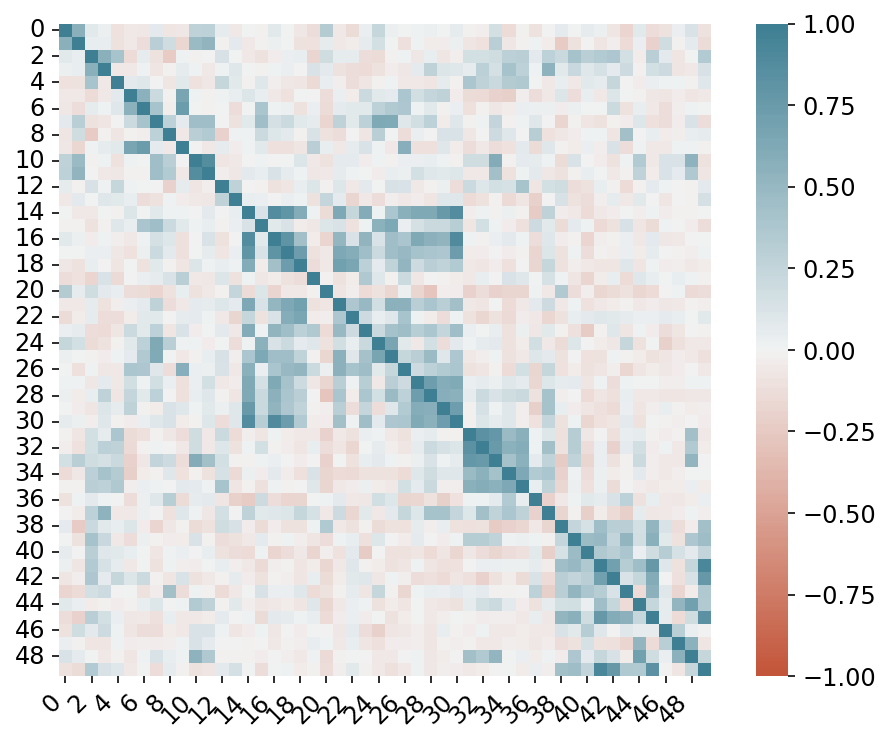

In [44]:
# Visualicemo la matriz de similitudes de las 50 primeras oraciones 

ax = sns.heatmap(
    distancias[:50,:50], 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Finalmente podemos mostrar las 5 oraciones más similares a una dada:

In [53]:
idx = 89

print(corpus_sent[idx].text)

print(f"\nLas 5 oraciones más similares son:\n")

idx_sim = np.argsort(-distancias[idx,:])

for i in range(6):
    if idx_sim[i] != idx:
        print(f"Oración {idx_sim[i]}\n")
        print(corpus_sent[idx_sim[i]].text)
        print('*****')


      It may buy the wheat, valued at 22.0 mln dlrs, between
  April 15 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.

Las 5 oraciones más similares son:

Oración 1647


      It may buy the wheat flour, valued at 23.0 mln dlrs between
  April 8 and August 31, 1987 and ship it by September 30, the
  department said.
*****
Oración 3372


      It may buy the wheat, valued at 7.0 mln dlrs, between March
  25 and August 341 and ship it from U.S. ports and/or Canadian
  transshipment points by September 30, 1987.
*****
Oración 3934


      It may buy the rice, valued at 5.5 mln dlrs, between March
  31 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.
*****
Oración 3246


      The department said it may buy the wheat, valued at 8.5 mln
  dlrs, the corn, valued at 1.5 mln, and the tallow, valued at
  2.0 mln dlrs, between March 24 and August 31, 1987, and ship it
  from U.S. ports and/or Canadian transshipme

Como vemos el resultado es razonable.

## 5.2 Combinaciones de word embeddings

Otra opción habitual para codificar un texto corto es utilizar la **media** de los word embeddings asociados a cada una de las palabras. Esta función está [directamente implementada en spaCy](https://spacy.io/usage/linguistic-features) cuando llamamos al método `.similarity` para calcular la similitud entre dos textos usando la distancia coseno entre las medias de los embeddings de cada uno de ellos: 

In [46]:
idx = 89

# Usamos corpus_sent --> todas las oraciones (listas de spacy.Doc) sin filtrar tokens.

print(corpus_sent[idx])

print(f"\nLas 5 oraciones más similares son:\n")

distancias_a_idx = np.array([corpus_sent[idx].similarity(s) for s in corpus_sent])

idx_sim = np.argsort(-distancias_a_idx)

for i in range(6):
    if idx_sim[i] != idx:
        print(f"Oración {idx_sim[i]}\n")
        print(corpus_sent[idx_sim[i]])
        print('*****')


      It may buy the wheat, valued at 22.0 mln dlrs, between
  April 15 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.

Las 5 oraciones más similares son:

Oración 3934


      It may buy the rice, valued at 5.5 mln dlrs, between March
  31 and August 31, 1987, and ship it from U.S. ports by
  September 30, the department said.
*****
Oración 1647


      It may buy the wheat flour, valued at 23.0 mln dlrs between
  April 8 and August 31, 1987 and ship it by September 30, the
  department said.
*****
Oración 3246


      The department said it may buy the wheat, valued at 8.5 mln
  dlrs, the corn, valued at 1.5 mln, and the tallow, valued at
  2.0 mln dlrs, between March 24 and August 31, 1987, and ship it
  from U.S. ports and/or Canadian transshipment points by this
  September 30.
*****
Oración 3372


      It may buy the wheat, valued at 7.0 mln dlrs, between March
  25 and August 341 and ship it from U.S. ports and/or Canadian
  transshipm

En lugar de calcular la media los embedding, otra alternativa sería la [media ponderada utilizando los coeficientes TF-IDF](https://arxiv.org/pdf/1902.09875.pdf). 

**Nota importante sobre el método `Doc.similarity()`**


Como hemos visto método `similarity` es accesible a través de la clase `Doc` de spaCy. Este método se pierde cuando filtrado los tokens no deseados. Por ejemplo la lista `norm_doc_sent` se había generado como

```python
norm_doc_sent = [[w for w in s if not w.is_stop and w.has_vector
                  and not w.is_punct and (w.is_alpha or w.is_digit)] for s in corpus_sent]

norm_doc_sent_text = [[w.text.lower() for w in s] for s in norm_doc_sent]
```

y podemos ver que obtenemos un error al intentar utilizar el método `similarity` ...


In [47]:
norm_doc_sent[0].similarity(norm_doc_sent[1])

AttributeError: 'list' object has no attribute 'similarity'

La opción más sencilla para volver a tener disponible este método, es generar de nuevo los strings a partir de los tokens

In [48]:
norm_doc_sent_extended = [nlp(' '.join(q)) for q in norm_doc_sent_text]

In [49]:
norm_doc_sent_extended[0].similarity(norm_doc_sent_extended[1])

0.8386437430755288

Usando `norm_doc_sent_extended` podemos encontrar las oraciones más simiares promediando sólo los embeddings de las palabras tras normalizar.

Alternativamente, podemos usar la opción [`spacy.tokens.doc.Doc()`](https://stackoverflow.com/questions/48169545/does-spacy-take-as-input-a-list-of-tokens), pero hay que pasar el diccionario y una secuencia que indica espacios entre tokens (necesaria para implementar algunas de las funcionalidades del pipeline de un modelo de lenguaje *spacy*). En este sentido la solución anterior parece más compacta.